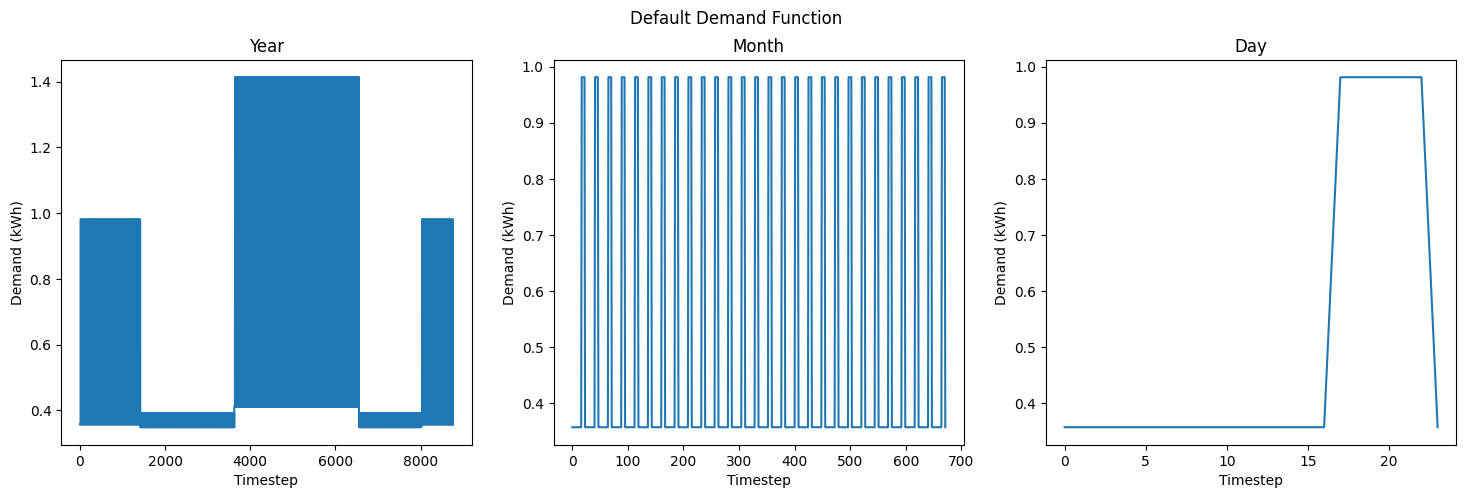

In [ ]:
import matplotlib.pyplot as plt

from defaults import _days_in_month, _price_default_fn

demand_full_year = [_price_default_fn(hour, day, month)
           for month in range(1, 13)
           for day in range(1, _days_in_month(month)+1)
           for hour in range(24)
          ]
demand_february = [_price_default_fn(hour, day, 2)
           for day in range(1, _days_in_month(2)+1)
           for hour in range(24)]
demand_february_27 = [_price_default_fn(hour, 27, 2)
              for hour in range(24)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

axes[0].plot(demand_full_year)
axes[0].set_title('Year')
axes[0].set_ylabel('Demand (kWh)')
axes[0].set_xlabel('Timestep')

axes[1].plot(demand_february)
axes[1].set_title('Month')
axes[1].set_ylabel('Demand (kWh)')
axes[1].set_xlabel('Timestep')

axes[2].plot(demand_february_27)
axes[2].set_title('Day')
axes[2].set_ylabel('Demand (kWh)')
axes[2].set_xlabel('Timestep')

fig.suptitle("Default Demand Function")

plt.savefig('images/default_demand.pdf', format='pdf', bbox_inches='tight')
plt.show()

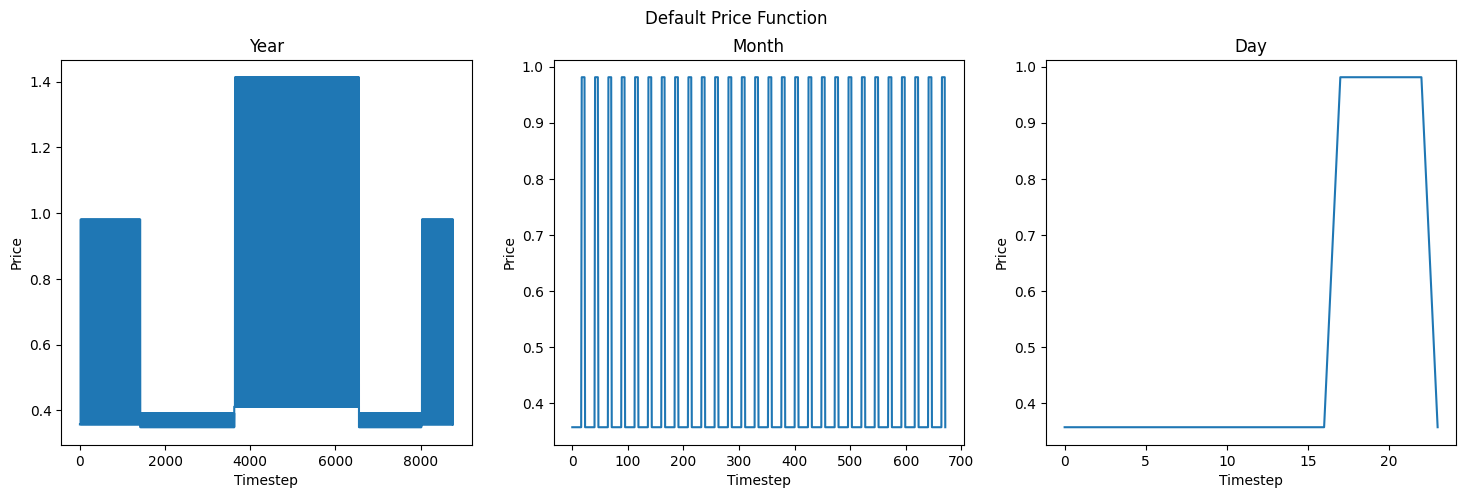

In [27]:
import matplotlib.pyplot as plt

from defaults import _days_in_month, _price_default_fn

price_full_year = [_price_default_fn(hour, day, month)
           for month in range(1, 13)
           for day in range(1, _days_in_month(month)+1)
           for hour in range(24)
          ]
price_february = [_price_default_fn(hour, day, 2)
           for day in range(1, _days_in_month(2)+1)
           for hour in range(24)]
price_february_27 = [_price_default_fn(hour, 27, 2)
              for hour in range(24)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

axes[0].plot(price_full_year)
axes[0].set_title('Year')
axes[0].set_ylabel('Price')
axes[0].set_xlabel('Timestep')

axes[1].plot(price_february)
axes[1].set_title('Month')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Timestep')

axes[2].plot(price_february_27)
axes[2].set_title('Day')
axes[2].set_ylabel('Price')
axes[2].set_xlabel('Timestep')

fig.suptitle("Default Price Function")

plt.savefig('images/default_price.pdf', format='pdf', bbox_inches='tight')
plt.show()